In [1]:
from packages import *
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.data.experimental import AUTOTUNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import re
from collections import Counter

import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.datasets import imdb

%load_ext autoreload
%autoreload 2

In [2]:
tf.__version__

'2.0.0-alpha0'

In [3]:
epsilon = 1e-7
fp = 'float32'
tf.config.gpu.set_per_process_memory_growth(True)
tf.config.gpu.set_per_process_memory_fraction(.4)
tf.keras.backend.set_floatx(fp)
tf.keras.backend.set_epsilon(epsilon)
tf.keras.backend.set_image_data_format('channels_last')

In [4]:
batch_size = 100
glove_dim = 50
input_shape = (300, glove_dim, 1)
max_length = 300
shuffle_buffer_size = batch_size*4
prefetch_buffer_size = 1
random_seed = np.random.randint(0, 100)
test_ratio = 0.33

In [5]:
def shuffle_sample(dictionary, n_sample=None, random_seed=42):
    lens = [len(l) for l in dictionary.values()]
    assert min(lens) == max(lens)
    n_data = lens[0]
    processed = {}
    for key, array in dictionary.items():
        if n_sample is not None:
            processed[key] = shuffle(array, random_state=random_seed)[:n_sample]
        else:
            processed[key] = shuffle(array, random_state=random_seed)[:n_sample]
    return processed

In [6]:
data = shuffle_sample(load_data({'review': ['text', 'stars']})['review'],
                             random_seed=random_seed
                            )
x_train, x_test, y_train, y_test = train_test_split(data['text'],
                                                    data['stars'],
                                                    test_size = test_ratio,
                                                   )

In [7]:
glove_lookup = load_pickle(os.path.join(GLOVE_DIR, 'glove-{}D.pkl'.format(glove_dim)))
unk_key = '<UNK>'

In [8]:
unk_vector = np.mean(np.array(list(glove_lookup.values())), axis=0)
glove_lookup[unk_key] = unk_vector

In [9]:
vocab_size = len(glove_lookup.keys())

In [10]:
print('Loading data...')
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train_tf = tf.data.Dataset.from_tensor_slices(x_train)
y_train_tf = tf.data.Dataset.from_tensor_slices(y_train - 1) # to make stars 0-indexed

x_test_tf = tf.data.Dataset.from_tensor_slices(x_test)
y_test_tf = tf.data.Dataset.from_tensor_slices(y_test - 1)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(
    np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(
    np.mean(list(map(len, x_test)), dtype=int)))

Loading data...
4479553 train sequences
2206347 test sequences
Average train sequence length: 602
Average test sequence length: 602


In [11]:
def clean_token(t):
    t = t.lower()
    m = re.match('^[^\w\'](\w+).*', t)
    if m is not None:
        return m.group(1)
    else:
        return t

def tokenize(s):
    tokens = []
    for t in word_tokenize(s):
        tokens.append(clean_token(t))
    return tokens

# Returns an np.array of glove embeddings for each
# word in the given string of shape (word_count, glove_dims)
def get_glove_embeddings(tokens):
    embeddings = []
    
    for i, word in enumerate(tokens):
#         if i > 
        if word in glove_lookup:
            embeddings.append(glove_lookup[word])
        else:
            embeddings.append(np.zeros(glove_dim))
            
#     return(np.array(embeddings, dtype=np.float16))
    return(np.array(embeddings, dtype=np.float32))

def test_embed(arr):
    return get_glove_embeddings(tokenize(arr))

def embed(tensor):
    return get_glove_embeddings(tokenize(str(tensor.numpy())))

@tf.function
def fix_dimensions(tensor):
    return tf.reshape(tf.image.resize_image_with_crop_or_pad(tf.expand_dims(tensor, axis=-1), 300, glove_dim), (300,50))

In [12]:
train_dataset_embed = tf.data.Dataset.map(x_train_tf,  lambda review: tf.py_function( embed, [review], tf.float32 ), num_parallel_calls=AUTOTUNE) 
test_dataset_embed = tf.data.Dataset.map(x_test_tf,  lambda review: tf.py_function( embed, [review], tf.float32 ),num_parallel_calls=AUTOTUNE) 

In [13]:
train_dataset_embed = tf.data.Dataset.map(train_dataset_embed, fix_dimensions, num_parallel_calls=AUTOTUNE) 
test_dataset_embed = tf.data.Dataset.map(test_dataset_embed, fix_dimensions, num_parallel_calls=AUTOTUNE) 

In [14]:
train_dataset = tf.data.Dataset.zip((train_dataset_embed, y_train_tf))
test_dataset = tf.data.Dataset.zip((test_dataset_embed, y_test_tf))

In [15]:
train_dataset = tf.data.Dataset.shuffle(train_dataset, buffer_size=shuffle_buffer_size)
test_dataset = tf.data.Dataset.shuffle(test_dataset, buffer_size=shuffle_buffer_size)

In [16]:
train_dataset = tf.data.Dataset.batch(train_dataset, batch_size=batch_size)
test_dataset = tf.data.Dataset.batch(test_dataset, batch_size=batch_size)

In [17]:
train_dataset = tf.data.Dataset.prefetch(train_dataset, buffer_size=prefetch_buffer_size)
test_dataset = tf.data.Dataset.prefetch(test_dataset, buffer_size=prefetch_buffer_size)

# Prep Data

In [18]:
# Step 1: Get data from tensor
X = []
Y = []
for x_batch, y_batch in train_dataset.take(10000 // batch_size):
    X.append(x_batch)
    Y.append(y_batch)

In [19]:
embed_dim = 128
lstm_out = 200
input_len = 300

In [20]:
class YelpLSTM:
    def __init__(self, hidden_size=5, output_dim=5):
        self.hidden_size = hidden_size
        self.output_dim = output_dim
    
    def build(self):
        inp = Input(shape=(input_len, glove_dim), name="input")
        #x = Embedding(2500, embed_dim, input_length = input_len)(inp)
        #x = Dropout(0.2)(x)
        x = LSTM(self.hidden_size)(inp)
        out = Dense(self.output_dim, activation="softmax")(x)
        return tf.keras.models.Model(inputs=inp, outputs=out)
        
    @tf.function
    def loss_fn(truth, logits):
        loss = tf.keras.losses.sparse_categorical_crossentropy(truth, logits)
        return loss

In [28]:
model = YelpLSTM(hidden_size=10)
model = model.build()
model.compile(optimizer="adam", metrics=['accuracy'] ,loss=YelpLSTM.loss_fn)
model.fit(train_dataset.take(200),
          epochs=5,
          #validation_split=.2,
          validation_data=test_dataset.take(200), validation_freq=1
         )

W0605 23:04:54.084853 140203855951680 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f82d46a4ac8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Epoch 1/5
200/200 [==============================] - 132s 659ms/step - loss: 1.4492 - accuracy: 0.0301 - val_loss: 1.3891 - val_accuracy: 0.0351
Epoch 2/5
200/200 [==============================] - 131s 655ms/step - loss: 1.3631 - accuracy: 0.0490 - val_loss: 1.3266 - val_accuracy: 0.0635
Epoch 3/5
200/200 [==============================] - 131s 654ms/step - loss: 1.2979 - accuracy: 0.2613 - val_loss: 1.2613 - val_accuracy: 0.3629
Epoch 4/5
200/200 [==============================] - 131s 656ms/step - loss: 1.2674 - accuracy: 0.3948 - val_loss: 1.2364 - val_accuracy: 0.3607
Epoch 5/5
200/200 [==============================] - 131s 655ms/step - loss: 1.2422 - accuracy: 0.3848 - val_loss: 1.2198 - val_accuracy: 0.3327


In [29]:
model = YelpLSTM(hidden_size=20)
model = model.build()
model.compile(optimizer="adam", metrics=['accuracy'] ,loss=YelpLSTM.loss_fn)
model.fit(train_dataset.take(200),
          epochs=5,
          #validation_split=.2,
          validation_data=test_dataset.take(200), validation_freq=1
         )

W0605 23:15:50.630335 140203855951680 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f82d42d95f8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Epoch 1/5
200/200 [==============================] - 132s 658ms/step - loss: 1.4473 - accuracy: 0.0510 - val_loss: 1.3940 - val_accuracy: 0.0432
Epoch 2/5
200/200 [==============================] - 131s 655ms/step - loss: 1.3280 - accuracy: 0.2346 - val_loss: 1.2935 - val_accuracy: 0.3620
Epoch 3/5
200/200 [==============================] - 131s 655ms/step - loss: 1.2814 - accuracy: 0.3286 - val_loss: 1.2378 - val_accuracy: 0.3742
Epoch 4/5
200/200 [==============================] - 131s 655ms/step - loss: 1.1899 - accuracy: 0.2669 - val_loss: 1.1775 - val_accuracy: 0.2939
Epoch 5/5
200/200 [==============================] - 131s 656ms/step - loss: 1.1510 - accuracy: 0.2436 - val_loss: 1.1536 - val_accuracy: 0.2692


In [30]:
model = YelpLSTM(hidden_size=50)
model = model.build()
model.compile(optimizer="adam", metrics=['accuracy'] ,loss=YelpLSTM.loss_fn)
model.fit(train_dataset.take(200),
          epochs=5,
          #validation_split=.2,
          validation_data=test_dataset.take(200), validation_freq=1
         )

W0605 23:26:47.036465 140203855951680 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f82d42b8630>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Epoch 1/5
200/200 [==============================] - 132s 660ms/step - loss: 1.4282 - accuracy: 0.0435 - val_loss: 1.3925 - val_accuracy: 0.0507
Epoch 2/5
200/200 [==============================] - 132s 659ms/step - loss: 1.4093 - accuracy: 0.0227 - val_loss: 1.4122 - val_accuracy: 0.0334
Epoch 3/5
199/200 [============================>.] - ETA: 0s - loss: 1.4134 - accuracy: 0.0461

KeyboardInterrupt: 

In [22]:
class YelpLSTM2:
    def __init__(self, hidden_size=20, dense_layer_dim=100, output_dim=5):
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        self.dense_layer_dim = dense_layer_dim
    
    def build(self):
        inp = Input(shape=(input_len, glove_dim), name="input")
        #x = Embedding(2500, embed_dim, input_length = input_len)(inp)
        x = LSTM(self.hidden_size)(inp)
        x = Dropout(0.2)(x)
        x = Dense(self.dense_layer_dim, activation="relu")(x)
        x = Dropout(0.2)(x)
        out = Dense(self.output_dim, activation="softmax")(x)
        return tf.keras.models.Model(inputs=inp, outputs=out)
        
    @tf.function
    def loss_fn(truth, logits):
        loss = tf.keras.losses.sparse_categorical_crossentropy(truth, logits)
        return loss

In [23]:
model = YelpLSTM2(hidden_size=20, dense_layer_dim=100)
model = model.build()
model.compile(optimizer="adam", metrics=['accuracy'] ,loss=YelpLSTM.loss_fn)
model.fit(train_dataset.take(200),
          epochs=5,
          #validation_split=.2,
          validation_data=test_dataset.take(200), validation_freq=1
         )

W0605 23:35:13.953759 139622214588224 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7efb511f9c18>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Epoch 1/5
200/200 [==============================] - 134s 672ms/step - loss: 1.4409 - accuracy: 0.0382 - val_loss: 1.4100 - val_accuracy: 0.0572
Epoch 2/5
200/200 [==============================] - 131s 657ms/step - loss: 1.3791 - accuracy: 0.0806 - val_loss: 1.3315 - val_accuracy: 0.1919
Epoch 3/5
200/200 [==============================] - 132s 658ms/step - loss: 1.2916 - accuracy: 0.2806 - val_loss: 1.2570 - val_accuracy: 0.3425
Epoch 4/5
200/200 [==============================] - 131s 657ms/step - loss: 1.2068 - accuracy: 0.2849 - val_loss: 1.1715 - val_accuracy: 0.2089
Epoch 5/5
200/200 [==============================] - 131s 656ms/step - loss: 1.1351 - accuracy: 0.2330 - val_loss: 1.1436 - val_accuracy: 0.1609


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300, 50)]         0         
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 20)                5680      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 8,285
Trainable params: 8,285
Non-trainable params: 0
___________________________________________________________

# Extra Feature Stuff

In [12]:
import spacy
from spacy import displacy

In [13]:
nlp = spacy.load('en')

In [23]:
i=0

In [24]:
doc = nlp(text[i])

In [ ]:
for token in doc:
    print("{0}/{1} <--{2}-- {3}/{4}".format(
        token.text, token.tag_, token.dep_, token.head.text, token.head.tag_))

In [ ]:
for token in doc:
    print("{0}:{1}".format(
        token.text, token.tag_))

In [ ]:
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

# Indexed Way

In [2]:
from packages import *
import pandas as pd
import tensorflow as tf
from datetime import datetime, timedelta
import time
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.data.experimental import AUTOTUNE
from sklearn.metrics import f1_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
%load_ext autoreload
%autoreload 2

In [3]:
tf.config.gpu.set_per_process_memory_growth(True)
tf.config.gpu.set_per_process_memory_fraction(.40)
tf.keras.backend.set_image_data_format('channels_last')

In [4]:
batch_size = 64
glove_dim = 300
input_len = 300
input_shape = (300, glove_dim, 1)
max_length = 300
shuffle_buffer_size = batch_size * 10
prefetch_buffer_size = 1
chunk_count = 100
random_seed = np.random.randint(0, 1000)
splits = ['train', 'val', 'test'] #80:10:10

In [5]:
tf_text_filenames = [os.path.join(DATASET_DIR, 'preprocessed', 'tfrecord', 'xext',  #xext temporarily
                                  'review-text-{:02d}.tf'.format(i)) for i in range(chunk_count)]
tf_ix_filenames = [os.path.join(DATASET_DIR, 'preprocessed', 'tfrecord', 'ix', 
                                  'review-ix-{:02d}.tf'.format(i)) for i in range(chunk_count)]
stars = (load_data({'review': ['stars']})['review']['stars'] - 1).astype(np.int32)# this is so that stars are 0-indexed
N = len(stars)
stars_chunked = stars.reshape((chunk_count, 6685900//chunk_count))

In [6]:
tf_text, tf_ix, stars= {}, {}, {}

In [7]:
tf_text['train'], tf_text_filenames_val_test, tf_ix['train'], tf_ix_filenames_val_test, stars['train'], stars_val_test \
= train_test_split(tf_text_filenames, tf_ix_filenames, stars_chunked, random_state=random_seed, test_size = .2)

In [8]:
tf_text['val'], tf_text['test'], tf_ix['val'], tf_ix['test'], stars['val'], stars['test'] \
= train_test_split(tf_text_filenames_val_test, tf_ix_filenames_val_test, stars_val_test, random_state=random_seed, test_size = .5)

In [9]:
for split in splits:
    stars[split] = stars[split].reshape(np.product(stars[split].shape))

In [10]:
print('({}:{}:{})'.format(len(tf_text['train']), len(tf_text['val']), len(tf_text['test'])))

(80:10:10)


In [11]:
glove_lookup = load_pickle(os.path.join(GLOVE_DIR, 'glove-{}D-byte-float32.pkl'.format(glove_dim)))
keys_to_ix = load_pickle(os.path.join(GLOVE_DIR, 'glove-byte-keys_to_ix.pkl'))
ix_to_key = {value: key for key, value in keys_to_ix.items()}

In [12]:
unk_vector = np.mean(np.array(list(glove_lookup.values())), axis=0)
null_vector = np.zeros(glove_dim)
glove_lookup[UNK_KEY.encode('ascii')] = unk_vector #if using byte glove dict
glove_lookup[NULL_KEY.encode('ascii')] = null_vector

In [13]:
oops = 0
glove_lookup_array = []
for i in range(len(ix_to_key)):
    if ix_to_key[i] not in glove_lookup:
        oops+=1
    glove_lookup_array.append(glove_lookup.get(ix_to_key[i], null_vector))
glove_lookup_array = np.array(glove_lookup_array, dtype=np.float32)
print('oops {} times.'.format(oops))

oops 1 times.


In [14]:
@tf.function
def _parse_function(proto, to_ix):
    # define your tfrecord again. Remember that you saved your image as a string.
    keys_to_features = {'review': tf.io.FixedLenFeature([300,], tf.int64) if to_ix else tf.io.FixedLenFeature([300,], tf.string),}
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    
    return parsed_features 

In [15]:
# tf_embedding = tf.Variable(
#         tf.constant(glove_lookup_array),
#         trainable=False,
#         name="Embedding"
# )

In [16]:
@tf.function
def embed(tensor):
    return tf.gather(glove_lookup_array, tensor)

In [17]:
@tf.function
def channelize(tensor):
    return tf.expand_dims(tensor, -1)

In [18]:
def make_lstm_dataset(embedded, to_ix=False):        
    if embedded or to_ix: 
        files = tf_ix
        to_ix = True
    else:
        files = tf_text
    dataset = {}
    for split in splits:
        dataset[split] = tf.data.TFRecordDataset(files[split])
        stars_dataset = tf.data.Dataset.from_tensor_slices(stars[split])
        dataset[split] = dataset[split].map(lambda x: _parse_function(x, to_ix)['review'], num_parallel_calls=AUTOTUNE)
        if embedded:
            dataset[split] = dataset[split].map(embed, num_parallel_calls=AUTOTUNE)
            #dataset[split] = dataset[split].map(channelize, num_parallel_calls=AUTOTUNE)
        dataset[split] = tf.data.Dataset.zip((dataset[split], stars_dataset))
        dataset[split] = dataset[split].shuffle(shuffle_buffer_size)
        dataset[split] = dataset[split].map(lambda x, y: ({'review': x}, {'stars': y}))
        dataset[split] = dataset[split].batch(batch_size)
        dataset[split] = dataset[split].prefetch(prefetch_buffer_size)
    return dataset

In [19]:
dataset = make_lstm_dataset(embedded=True)

## Models

In [20]:
def sanity_check(model, dataset):
    print("TRAIN:")
    for i in dataset['train']:
        break
    print(i[1])
    print(np.argmax(model.predict_on_batch(i[0]['review'])['stars'], axis=1))
    print("TEST:")
    for i in dataset['test']:
        break
    print(i[1])
    print(np.argmax(model.predict_on_batch(i[0]['review'])['stars'], axis=1))

In [40]:
num_epochs=1

In [22]:
class Levreki:
    def __init__(self, lstm_size=5, output_dim=5, input_shape=(300,50)):
        self.lstm_size = lstm_size
        self.output_dim = output_dim
        self.input_shape = input_shape
    
    def build(self):
        inputs = Input(shape=self.input_shape, name='review')
        #x = Embedding(2500, embed_dim, input_length = input_len)(inp)
        #x = Dropout(0.2)(x)
        x = LSTM(self.lstm_size, name="LSTM")(inputs)
        outputs = Dense(self.output_dim, activation="softmax", name="stars")(x)
        return tf.keras.models.Model(inputs={'review' : inputs}, outputs={'stars': outputs}, name='Levreki')
    
    def get_params(self):
        return {
            'lstm_size' : self.lstm_size
        }

    def get_param_string(self):
        return "{}_{}cells".format(self.name, self.lstm_size)

In [23]:
class Tilapia:
    def __init__(self, lstm_size=5, dense_size=1000, output_dim=5, input_shape=(300,50)):
        self.lstm_size = lstm_size
        self.output_dim = output_dim
        self.dense_size = dense_size
        self.input_shape = input_shape
    
    def build(self):
        inputs = Input(shape=self.input_shape, name='review')
        #x = Dropout(0.2)(x)
        x = LSTM(self.lstm_size, name="LSTM_1")(inputs)
        x = Dense(self.dense_size, name="dense_1")(x)
        outputs = Dense(self.output_dim, activation="softmax", name="stars")(x)
        return tf.keras.models.Model(inputs={'review' : inputs}, outputs={'stars': outputs}, name='Tilapia')

    def get_params(self):
        return {
            'lstm_size' : self.lstm_size,
            'dense_size': self.dense_size
        }

    def get_param_string(self):
        return "{}_{}cells_{}dense".format(self.name, self.lstm_size, self.dense_size)

In [ ]:
super_blueberry = 

In [57]:
levreki = Levreki(lstm_size=5, output_dim=5, input_shape=(input_len, glove_dim)).build()
levreki.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
log_dir = os.path.join(SRC_DIR, 'logs', 'LSTM_5cell_{}'.format(datetime.fromtimestamp(time.time()).strftime('%H-%M-%S_%Y-%m-%d')))
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=False, update_freq='batch')
levreki.summary()
levreki.fit(dataset['train'].take(1000),
            epochs=num_epochs,
            validation_data = dataset['val'].take(1000),
            callbacks=[tb])
sanity_check(levreki, dataset)

W0606 13:55:30.268415 139888336217920 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f39f0b916d8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "Levreki"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review (InputLayer)          [(None, 300, 300)]        0         
_________________________________________________________________
LSTM (UnifiedLSTM)           (None, 5)                 6120      
_________________________________________________________________
stars (Dense)                (None, 5)                 30        
Total params: 6,150
Trainable params: 6,150
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1000/1000 [==============================] - 72s 72ms/step - loss: 1.4169 - sparse_categorical_accuracy: 0.4536 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
1000/1000 [==============================] - 70s 70ms/step - loss: 1.3304 - sparse_categorical_accuracy: 0.4957 - val_loss: 1.3127 - val_sparse_categorical_accuracy: 0.5134
Epoch 3/10


In [24]:
levreki_10cell = Levreki(lstm_size=10, output_dim=5, input_shape=(input_len, glove_dim)).build()
levreki_10cell.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
log_dir = os.path.join(SRC_DIR, 'logs', 'LSTM_10cell_{}'.format(datetime.fromtimestamp(time.time()).strftime('%H-%M-%S_%Y-%m-%d')))
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=False, update_freq='batch')
levreki_10cell.summary()
levreki_10cell.fit(dataset['train'].take(1000),
                   epochs=num_epochs,
                   validation_data = dataset['val'].take(1000),
                  callbacks = [tb])
sanity_check(levreki_10cell, dataset)

W0606 14:26:05.382736 140323491501888 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9f563f1358>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "Levreki"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review (InputLayer)          [(None, 300, 300)]        0         
_________________________________________________________________
LSTM (UnifiedLSTM)           (None, 10)                12440     
_________________________________________________________________
stars (Dense)                (None, 5)                 55        
Total params: 12,495
Trainable params: 12,495
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
      1/Unknown - 2s 2s/step - loss: 1.6110 - sparse_categorical_accuracy: 0.0938

W0606 14:26:09.510894 140323491501888 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.132141). Check your callbacks.


1000/1000 [==============================] - 84s 84ms/step - loss: 1.4221 - sparse_categorical_accuracy: 0.4368 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/5
1000/1000 [==============================] - 82s 82ms/step - loss: 1.3752 - sparse_categorical_accuracy: 0.4419 - val_loss: 1.2726 - val_sparse_categorical_accuracy: 0.4589
Epoch 3/5
1000/1000 [==============================] - 82s 82ms/step - loss: 1.4152 - sparse_categorical_accuracy: 0.4401 - val_loss: 1.3574 - val_sparse_categorical_accuracy: 0.4534
Epoch 4/5
1000/1000 [==============================] - 85s 85ms/step - loss: 1.3887 - sparse_categorical_accuracy: 0.4376 - val_loss: 1.4012 - val_sparse_categorical_accuracy: 0.4534
Epoch 5/5
1000/1000 [==============================] - 94s 94ms/step - loss: 1.3872 - sparse_categorical_accuracy: 0.4452 - val_loss: 1.3137 - val_sparse_categorical_accuracy: 0.4558
TRAIN:
{'stars': <tf.Tensor: id=2965997, shape=(64,), dtype=int32, numpy=
array([2, 1, 

In [26]:
tilapia = Tilapia(lstm_size=5, dense_size=100, output_dim=5, input_shape=(input_len, glove_dim)).build()
tilapia.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
log_dir = os.path.join(SRC_DIR, 'logs', 'tilapia_5cell_100dense_{}'.format(datetime.fromtimestamp(time.time()).strftime('%H-%M-%S_%Y-%m-%d')))
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=False, update_freq='batch')
tilapia.summary()
tilapia.fit(dataset['train'].take(1000),
            epochs=num_epochs,
            validation_data = dataset['val'].take(1000),
            callbacks = [tb])
sanity_check(tilapia, dataset)

W0606 14:51:22.128246 140323491501888 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9f5631c860>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "Tilapia"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review (InputLayer)          [(None, 300, 300)]        0         
_________________________________________________________________
LSTM_1 (UnifiedLSTM)         (None, 5)                 6120      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
stars (Dense)                (None, 5)                 505       
Total params: 7,225
Trainable params: 7,225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1000/1000 [==============================] - 104s 104ms/step - loss: 1.4180 - sparse_categorical_accuracy: 0.4353 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/5
1000/1000 [==============================] - 105s 10

In [41]:
tilapia_1000cell = Tilapia(lstm_size=5, dense_size=100, output_dim=5, input_shape=(input_len, glove_dim)).build()
tilapia_1000cell.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
log_dir = os.path.join(SRC_DIR, 'logs', 'tilapia_5cell_100dense_{}'.format(datetime.fromtimestamp(time.time()).strftime('%H-%M-%S_%Y-%m-%d')))
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=False, update_freq='batch')
tilapia_1000cell.summary()
tilapia_1000cell.fit(dataset['train'],
            epochs=num_epochs,
            validation_data = dataset['val'],
            callbacks = [tb])
sanity_check(tilapia_1000cell, dataset)

W0606 15:23:45.837588 140323491501888 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9ed8630320>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "Tilapia"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review (InputLayer)          [(None, 300, 300)]        0         
_________________________________________________________________
LSTM_1 (UnifiedLSTM)         (None, 5)                 6120      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
stars (Dense)                (None, 5)                 505       
Total params: 7,225
Trainable params: 7,225
Non-trainable params: 0
_________________________________________________________________
   2305/Unknown - 153s 66ms/step - loss: 1.3912 - sparse_categorical_accuracy: 0.4456

KeyboardInterrupt: 

In [29]:
from tensorflow.keras.utils import plot_model

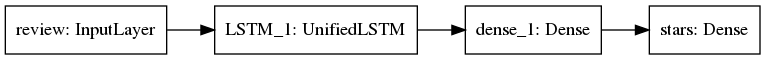

In [39]:
plot_model(tilapia, show_shapes=False, show_layer_names=True, rankdir="LR")